In [1]:
#Need to compare the BERT model with the regular SVM model 

In [10]:
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import pickle
import os
from sklearn.metrics import classification_report, accuracy_score, f1_score, plot_confusion_matrix,ConfusionMatrixDisplay, confusion_matrix
import pickle
os.environ["WANDB_DISABLED"] = "true"

In [11]:
model_name = "bert-base-uncased"
max_length=128

In [12]:
#loading the label encoder
le = pickle.load(open("Data/label_encoder.pkl", "rb"))

In [13]:
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [14]:
target_names=le.transform(le.classes_)

In [15]:
def preprocess_function(examples):
    #print(examples['TEXT'])
    return tokenizer(examples["text"], padding=True, truncation=True)
    #return toknizer(examples["text"],padding='max_length',truncation=True, max_length=max_length)

In [16]:
    
params = {
	  "per_gpu_batch_size": [8, 16, 32],
	  "learning_rate": [2e-5, 3e-5, 5e-5],
	  "num_epochs": [20, 30, 40]
	}

    

In [17]:
#traying 5 combinations first
import random
params_combos = []
i = 0
while i<10:
    first = random.randint(0,2)
    second = random.randint(0,2)
    third = random.randint(0,2)
    param = {"batch_size": params["per_gpu_batch_size"][first],
             "lr": params["learning_rate"][second],
             "epochs": params["num_epochs"][third]}
    if param not in params_combos:
        params_combos.append(param)
        i+=1

In [18]:
params_combos

[{'batch_size': 32, 'lr': 2e-05, 'epochs': 20},
 {'batch_size': 8, 'lr': 5e-05, 'epochs': 40},
 {'batch_size': 32, 'lr': 3e-05, 'epochs': 40},
 {'batch_size': 8, 'lr': 2e-05, 'epochs': 30},
 {'batch_size': 16, 'lr': 2e-05, 'epochs': 40},
 {'batch_size': 8, 'lr': 3e-05, 'epochs': 40},
 {'batch_size': 16, 'lr': 5e-05, 'epochs': 40},
 {'batch_size': 16, 'lr': 3e-05, 'epochs': 40},
 {'batch_size': 16, 'lr': 2e-05, 'epochs': 30},
 {'batch_size': 16, 'lr': 5e-05, 'epochs': 20}]

In [36]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to("cuda")
    
    # perform inference to our model
    outputs = model(**inputs)
    #print(outputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    #print(outputs[0].softmax(1).argmax())
    # executing argmax function to get the candidate label
    #print(probs)
    return probs.argmax().item()

## Kfold

In [150]:
#Run kfold over here 
results = []
f1_scores = []
best_model =[]
for i in range(5):
    train_dataset = load_dataset('csv', data_files={'train': 'Data/split_train_'+ str(i)+'.csv'})
    testing_dataset =load_dataset("csv", data_files={'test':'Data/split_test_'+ str(i)+'.csv'}) 
    #print(train_dataset["train"][0])

    tokenized_dataset_train =train_dataset.map(preprocess_function)
    #print(tokenized_dataset_train['train']['input_ids'])

    tokenized_dataset_test = testing_dataset.map(preprocess_function)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    #dataset has been loaded correctly. 
    print("----------------------MODEL 1--------------------------------")

    for p in params_combos:
        
        print("Combination: ", p)
        
        model=BertForSequenceClassification.from_pretrained(model_name, num_labels=13)
        #device="cpu"
        device="cuda"
        model.to(device)


        training_args = TrainingArguments(
        num_train_epochs=p["epochs"],
        learning_rate=p["lr"],
        per_device_train_batch_size=p["batch_size"],  # batch size per device during training
        weight_decay=0.01,               # strength of weight decay
        #oad_best_model_at_end=True,
        logging_steps=100,
        #valuation_strategy="steps",
        output_dir="Models/BERT_13classes"
        )

        trainer = Trainer( model=model,
                      args=training_args,
                      train_dataset=tokenized_dataset_train['train'],
                      #eval_dataset=tokenized_dataset_valid['valid'],
                      tokenizer=tokenizer,
                      data_collator=data_collator
                     )


        trainer.train()

        y_pred=[]

        for text in tokenized_dataset_test["test"]["text"]:
            y_pred.append(get_prediction(text))

        predictions = le.inverse_transform(y_pred)
        y_true = tokenized_dataset_test['test']["label"]
        
        f1= f1_score(le.inverse_transform(y_true), predictions, average="macro")
        f1_scores.append(f1)
        
        if f1 > max(f1_scores):
            best_model = {'split': i, 
                          'params': p,
                          'f1_score': f1,
                          'accuracy': acc}

        acc = accuracy_score(le.inverse_transform(y_true), predictions)
        results.append(acc)
        print(classification_report(le.inverse_transform(y_true), predictions))

Using custom data configuration default-39460bdd07acc7bf
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-39460bdd07acc7bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-38d3ac2bff9f4eb2
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-38d3ac2bff9f4eb2\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-39460bdd07acc7bf\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-0c03d44608866328.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-38d3ac2bff9f4eb2\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-96dbeb40b209ba5f.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
 

----------------------MODEL 1--------------------------------
Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.508200
200,0.467600
300,0.195400
400,0.122000




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.80      0.89         5
          fa       1.00      1.00      1.00         6
          fe       0.87      1.00      0.93        13
          fp       0.80      0.89      0.84         9
          ft       1.00      0.90      0.95        10
           n       0.86      0.92      0.89        13
         n-d       0.00      0.00      0.00         2
       query       1.00      1.00      1.00         4
         sno       0.89      0.90      0.90        83
          so       0.29      0.40      0.33         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.20      0.33         5

    accuracy                           0.87       166
   macro avg       0.81      0.77      0.77       166
weighted avg       0.88      0.87      0.86       166

Combination:  {'batch_size': 32, 'lr': 3e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.414600
200,0.280400
300,0.070500
400,0.043900




Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0"

              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.81      1.00      0.90        13
          fp       1.00      0.78      0.88         9
          ft       1.00      0.90      0.95        10
           n       0.80      0.92      0.86        13
         n-d       1.00      0.50      0.67         2
       query       1.00      0.75      0.86         4
         sno       0.91      0.88      0.90        83
          so       0.38      0.60      0.46         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.87       166
   macro avg       0.87      0.83      0.83       166
weighted avg       0.89      0.87      0.88       166

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,2.042100
200,1.268800
300,0.612500
400,0.354500
500,0.200700
600,0.108400
700,0.085200
800,0.050600
900,0.017600
1000,0.038500


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.87      1.00      0.93        13
          fp       0.88      0.78      0.82         9
          ft       1.00      1.00      1.00        10
           n       0.92      0.92      0.92        13
         n-d       1.00      0.50      0.67         2
       query       1.00      0.75      0.86         4
         sno       0.92      0.94      0.93        83
          so       0.40      0.40      0.40         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.90       166
   macro avg       0.90      0.82      0.85       166
weighted avg       0.91      0.90      0.90       166

Combination:  {'batch_size': 8, 'lr': 5e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.516600
200,0.637000
300,0.322600
400,0.182500
500,0.084800
600,0.053100
700,0.036600
800,0.035800
900,0.009600
1000,0.033000


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.93      1.00      0.96        13
          fp       0.80      0.89      0.84         9
          ft       1.00      0.90      0.95        10
           n       0.86      0.92      0.89        13
         n-d       0.00      0.00      0.00         2
       query       1.00      1.00      1.00         4
         sno       0.89      0.90      0.90        83
          so       0.00      0.00      0.00         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.87       166
   macro avg       0.78      0.77      0.77       166
weighted avg       0.87      0.87      0.87       166

Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.460400
200,0.417300
300,0.122900
400,0.055700
500,0.040400
600,0.030900
700,0.027100
800,0.026400


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.79      0.85      0.81        13
          fp       1.00      0.78      0.88         9
          ft       1.00      0.90      0.95        10
           n       0.86      0.92      0.89        13
         n-d       1.00      0.50      0.67         2
       query       1.00      1.00      1.00         4
         sno       0.90      0.93      0.91        83
          so       0.60      0.60      0.60         5
           y       0.89      1.00      0.94         8
         y-d       0.67      0.40      0.50         5

    accuracy                           0.89       166
   macro avg       0.88      0.82      0.84       166
weighted avg       0.89      0.89      0.88       166

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 20}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.664000
200,0.662100
300,0.262700
400,0.134100
500,0.061200
600,0.049100
700,0.038800
800,0.036100


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       0.60      1.00      0.75         3
         dno       1.00      0.80      0.89         5
          fa       1.00      1.00      1.00         6
          fe       0.85      0.85      0.85        13
          fp       1.00      0.89      0.94         9
          ft       1.00      1.00      1.00        10
           n       0.86      0.92      0.89        13
         n-d       1.00      0.50      0.67         2
       query       1.00      1.00      1.00         4
         sno       0.91      0.93      0.92        83
          so       0.40      0.40      0.40         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.40      0.57         5

    accuracy                           0.89       166
   macro avg       0.88      0.82      0.83       166
weighted avg       0.90      0.89      0.89       166

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 20}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,2.043300
200,1.267900
300,0.637500
400,0.359500
500,0.206300
600,0.111900
700,0.093100
800,0.067800
900,0.024200
1000,0.043500


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.80      0.89         5
          fa       1.00      1.00      1.00         6
          fe       0.87      1.00      0.93        13
          fp       0.78      0.78      0.78         9
          ft       1.00      1.00      1.00        10
           n       0.80      0.92      0.86        13
         n-d       1.00      0.50      0.67         2
       query       1.00      0.75      0.86         4
         sno       0.89      0.92      0.90        83
          so       0.00      0.00      0.00         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.88       166
   macro avg       0.86      0.79      0.81       166
weighted avg       0.87      0.88      0.87       166

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.129900
200,0.145300
300,0.034300
400,0.025300




Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.92      0.92      0.92        13
          fp       0.89      0.89      0.89         9
          ft       1.00      0.90      0.95        10
           n       0.92      0.85      0.88        13
         n-d       0.67      1.00      0.80         2
       query       1.00      0.75      0.86         4
         sno       0.90      0.89      0.90        83
          so       0.25      0.40      0.31         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.87       166
   macro avg       0.85      0.85      0.83       166
weighted avg       0.89      0.87      0.88       166

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 40}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.124400
200,0.133000
300,0.029900
400,0.021800
500,0.019900
600,0.017400
700,0.015800
800,0.016100


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       0.80      0.80      0.80         5
          fa       0.86      1.00      0.92         6
          fe       0.86      0.92      0.89        13
          fp       0.88      0.78      0.82         9
          ft       1.00      0.90      0.95        10
           n       0.87      1.00      0.93        13
         n-d       1.00      0.50      0.67         2
       query       1.00      0.75      0.86         4
         sno       0.90      0.89      0.90        83
          so       0.29      0.40      0.33         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.87       166
   macro avg       0.87      0.81      0.83       166
weighted avg       0.88      0.87      0.87       166

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 30}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.658100
200,0.649800
300,0.243500
400,0.117000
500,0.050700
600,0.040600
700,0.030800
800,0.029100
900,0.025700
1000,0.024000


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Using custom data configuration default-c94492fa8977105f
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datase

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       0.80      0.80      0.80         5
          fa       1.00      1.00      1.00         6
          fe       0.86      0.92      0.89        13
          fp       1.00      0.78      0.88         9
          ft       1.00      1.00      1.00        10
           n       0.75      0.92      0.83        13
         n-d       0.00      0.00      0.00         2
       query       0.75      0.75      0.75         4
         sno       0.90      0.90      0.90        83
          so       0.33      0.40      0.36         5
           y       0.89      1.00      0.94         8
         y-d       1.00      0.40      0.57         5

    accuracy                           0.87       166
   macro avg       0.79      0.76      0.76       166
weighted avg       0.87      0.87      0.86       166



  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b39b13b3f218eb93
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-b39b13b3f218eb93\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-c94492fa8977105f\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-64e36aca893dd606.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-b39b13b3f218eb93\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-ec3292cc75413797.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
 

----------------------MODEL 1--------------------------------
Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.501500
200,0.424700
300,0.184200
400,0.116600




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.50      0.50      0.50         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.82      0.90        11
          fp       0.93      0.87      0.90        15
          ft       1.00      1.00      1.00         6
           n       0.90      0.90      0.90        10
         n-d       0.00      0.00      0.00         2
       query       0.71      1.00      0.83         5
         sno       0.86      0.86      0.86        81
          so       0.22      0.33      0.27         6
           y       0.67      1.00      0.80         8
         y-d       1.00      0.40      0.57         5

    accuracy                           0.82       166
   macro avg       0.67      0.66      0.65       166
weighted avg       0.83      0.82      0.82       166

Combination:  {'batch_size': 32, 'lr': 3e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.449200
200,0.313700
300,0.091600
400,0.052200




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.91      0.95        11
          fp       0.93      0.87      0.90        15
          ft       1.00      1.00      1.00         6
           n       0.64      0.90      0.75        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.90      0.89      0.89        81
          so       0.57      0.67      0.62         6
           y       0.73      1.00      0.84         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.86       166
   macro avg       0.70      0.71      0.70       166
weighted avg       0.85      0.86      0.85       166

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 40}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.937700
200,1.064000
300,0.547500
400,0.288300
500,0.163500
600,0.099400
700,0.070400
800,0.039100
900,0.047000
1000,0.034900


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.73      0.84        11
          fp       0.93      0.87      0.90        15
          ft       1.00      1.00      1.00         6
           n       0.69      0.90      0.78        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.87      0.89      0.88        81
          so       0.57      0.67      0.62         6
           y       0.73      1.00      0.84         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.84       166
   macro avg       0.70      0.70      0.69       166
weighted avg       0.84      0.84      0.84       166

Combination:  {'batch_size': 8, 'lr': 5e-05, 'epochs': 40}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.565300
200,0.685500
300,0.320500
400,0.211700
500,0.122800
600,0.071000
700,0.043700
800,0.040500
900,0.044200
1000,0.031700


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.67      0.67      0.67         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.73      0.84        11
          fp       1.00      0.87      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.80      0.80      0.80        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.87      0.90      0.88        81
          so       0.60      0.50      0.55         6
           y       0.73      1.00      0.84         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.84       166
   macro avg       0.72      0.69      0.70       166
weighted avg       0.86      0.84      0.84       166

Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.470400
200,0.407200
300,0.126100
400,0.060600
500,0.045000
600,0.035200
700,0.032400
800,0.027200


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
 

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.50      0.50      0.50         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.91      0.95        11
          fp       0.93      0.93      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.69      0.90      0.78        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.92      0.89      0.91        81
          so       0.50      0.50      0.50         6
           y       0.73      1.00      0.84         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.86       166
   macro avg       0.69      0.70      0.69       166
weighted avg       0.86      0.86      0.85       166

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.685800
200,0.696200
300,0.295100
400,0.154100
500,0.086700
600,0.059300
700,0.048300
800,0.043900


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.73      0.84        11
          fp       0.88      0.93      0.90        15
          ft       1.00      1.00      1.00         6
           n       0.82      0.90      0.86        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.91      0.93      0.92        81
          so       0.38      0.50      0.43         6
           y       0.80      1.00      0.89         8
         y-d       1.00      0.80      0.89         5

    accuracy                           0.87       166
   macro avg       0.70      0.71      0.70       166
weighted avg       0.86      0.87      0.86       166

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.932000
200,1.021900
300,0.522900
400,0.292900
500,0.163000
600,0.099800
700,0.076700
800,0.040000
900,0.044800
1000,0.037100


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.73      0.84        11
          fp       1.00      0.87      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.69      0.90      0.78        10
         n-d       0.00      0.00      0.00         2
       query       0.71      1.00      0.83         5
         sno       0.87      0.88      0.87        81
          so       0.57      0.67      0.62         6
           y       0.67      1.00      0.80         8
         y-d       1.00      0.40      0.57         5

    accuracy                           0.83       166
   macro avg       0.69      0.68      0.67       166
weighted avg       0.84      0.83      0.83       166

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.191700
200,0.166000
300,0.046400
400,0.030300




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.60      0.50      0.55         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.82      0.90        11
          fp       1.00      0.87      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.64      0.90      0.75        10
         n-d       0.00      0.00      0.00         2
       query       0.62      1.00      0.77         5
         sno       0.92      0.88      0.90        81
          so       0.44      0.67      0.53         6
           y       0.73      1.00      0.84         8
         y-d       1.00      0.60      0.75         5

    accuracy                           0.84       166
   macro avg       0.68      0.70      0.68       166
weighted avg       0.86      0.84      0.84       166

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.173900
200,0.139400
300,0.049400
400,0.028800
500,0.023800
600,0.019600
700,0.018000
800,0.015900


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.67      0.67      0.67         6
          fa       0.90      0.90      0.90        10
          fe       0.90      0.82      0.86        11
          fp       1.00      0.87      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.69      0.90      0.78        10
         n-d       0.00      0.00      0.00         2
       query       0.83      1.00      0.91         5
         sno       0.88      0.89      0.88        81
          so       0.60      0.50      0.55         6
           y       0.89      1.00      0.94         8
         y-d       1.00      1.00      1.00         5

    accuracy                           0.86       166
   macro avg       0.72      0.73      0.72       166
weighted avg       0.85      0.86      0.86       166

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 30}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.679700
200,0.677000
300,0.273100
400,0.133600
500,0.071500
600,0.046100
700,0.040100
800,0.036900
900,0.031100
1000,0.028200


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       0.00      0.00      0.00         1
         dno       0.50      0.50      0.50         6
          fa       0.90      0.90      0.90        10
          fe       1.00      0.73      0.84        11
          fp       0.93      0.93      0.93        15
          ft       1.00      1.00      1.00         6
           n       0.82      0.90      0.86        10
         n-d       0.00      0.00      0.00         2
       query       0.71      1.00      0.83         5
         sno       0.92      0.88      0.90        81
          so       0.30      0.50      0.37         6
           y       0.80      1.00      0.89         8
         y-d       1.00      0.80      0.89         5

    accuracy                           0.84       166
   macro avg       0.68      0.70      0.69       166
weighted avg       0.86      0.84      0.85       166



Using custom data configuration default-98ddc8d7580f8bc3
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-98ddc8d7580f8bc3\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b99673641499d8f3
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-b99673641499d8f3\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-98ddc8d7580f8bc3\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-4c0b0d8e8ad7522e.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-b99673641499d8f3\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-49089b73dceb9b21.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
 

----------------------MODEL 1--------------------------------
Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.525100
200,0.489000
300,0.230500
400,0.146400




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       0.85      0.79      0.81        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.85      0.85      0.85        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       1.00      0.86      0.92         7
         sno       0.90      0.99      0.94        73
          so       1.00      0.50      0.67         4
           y       1.00      0.80      0.89        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.91       165
   macro avg       0.82      0.80      0.79       165
weighted avg       0.91      0.91      0.90       165

Combination:  {'batch_size': 32, 'lr': 3e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.373600
200,0.269400
300,0.087000
400,0.050900




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       1.00      0.79      0.88        14
          fa       1.00      0.92      0.96        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.89      0.94         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.88      0.99      0.93        73
          so       0.50      0.50      0.50         4
           y       1.00      0.70      0.82        10
         y-d       0.50      0.50      0.50         2

    accuracy                           0.90       165
   macro avg       0.77      0.76      0.76       165
weighted avg       0.90      0.90      0.89       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 40}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.992000
200,1.072700
300,0.610000
400,0.337900
500,0.205900
600,0.127500
700,0.079100
800,0.064900
900,0.055600
1000,0.040200


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       0.92      0.79      0.85        14
          fa       1.00      1.00      1.00        12
          fe       1.00      1.00      1.00        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.89      0.94         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.91      0.95      0.93        73
          so       0.29      0.50      0.36         4
           y       1.00      0.70      0.82        10
         y-d       0.50      0.50      0.50         2

    accuracy                           0.89       165
   macro avg       0.75      0.77      0.75       165
weighted avg       0.90      0.89      0.89       165

Combination:  {'batch_size': 8, 'lr': 5e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.557100
200,0.619800
300,0.346200
400,0.187000
500,0.102000
600,0.063400
700,0.052000
800,0.049900
900,0.053900
1000,0.031900


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       1.00      0.79      0.88        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       1.00      1.00      1.00         1
       query       0.86      0.86      0.86         7
         sno       0.90      0.99      0.94        73
          so       1.00      0.50      0.67         4
           y       0.89      0.80      0.84        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.92       165
   macro avg       0.89      0.88      0.87       165
weighted avg       0.92      0.92      0.91       165

Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.509400
200,0.457500
300,0.147800
400,0.068500
500,0.048700
600,0.038800
700,0.037500
800,0.036800


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

              precision    recall  f1-score   support

         ack       0.33      1.00      0.50         1
         dno       1.00      0.86      0.92        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.90      1.00      0.95        73
          so       1.00      0.50      0.67         4
           y       1.00      0.70      0.82        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.92       165
   macro avg       0.81      0.80      0.78       165
weighted avg       0.92      0.92      0.91       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.666300
200,0.768300
300,0.330700
400,0.166500
500,0.093400
600,0.061400
700,0.050800
800,0.048900


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
 

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       0.92      0.79      0.85        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.90      0.99      0.94        73
          so       1.00      0.50      0.67         4
           y       1.00      0.80      0.89        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.91       165
   macro avg       0.82      0.80      0.79       165
weighted avg       0.92      0.91      0.91       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.995400
200,1.090000
300,0.612100
400,0.352500
500,0.221700
600,0.139600
700,0.096700
800,0.075800
900,0.062000
1000,0.044100


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       0.92      0.79      0.85        14
          fa       1.00      0.92      0.96        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.89      0.96      0.92        73
          so       0.40      0.50      0.44         4
           y       1.00      0.80      0.89        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.89       165
   macro avg       0.77      0.80      0.77       165
weighted avg       0.90      0.89      0.89       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.337300
200,0.178500
300,0.052600
400,0.032000




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         1
         dno       1.00      0.79      0.88        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.89      0.94         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.90      0.95      0.92        73
          so       0.25      0.50      0.33         4
           y       1.00      0.70      0.82        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.89       165
   macro avg       0.81      0.80      0.79       165
weighted avg       0.91      0.89      0.89       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.337400
200,0.156500
300,0.058600
400,0.032000
500,0.029500
600,0.021700
700,0.022700
800,0.023200


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       1.00      0.86      0.92        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.82      0.90        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       0.88      0.78      0.82         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.89      0.97      0.93        73
          so       0.67      0.50      0.57         4
           y       1.00      0.70      0.82        10
         y-d       0.50      1.00      0.67         2

    accuracy                           0.90       165
   macro avg       0.78      0.79      0.77       165
weighted avg       0.90      0.90      0.89       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 30}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.663700
200,0.759000
300,0.306700
400,0.140300
500,0.077900
600,0.050400
700,0.042200
800,0.042500
900,0.036800
1000,0.037100


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       1.00      0.86      0.92        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.82      0.90        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       0.00      0.00      0.00         1
       query       0.86      0.86      0.86         7
         sno       0.89      1.00      0.94        73
          so       0.67      0.50      0.57         4
           y       1.00      0.70      0.82        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.91       165
   macro avg       0.80      0.80      0.78       165
weighted avg       0.91      0.91      0.90       165



Using custom data configuration default-bbdf4ddd915aa9c5
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-bbdf4ddd915aa9c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-9bb1bee6ba541638
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-9bb1bee6ba541638\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-bbdf4ddd915aa9c5\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-f2e42b6cc0805d1e.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-9bb1bee6ba541638\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-c26567e1cc560e28.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


----------------------MODEL 1--------------------------------
Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 20}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.508000
200,0.425300
300,0.181600
400,0.113700




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       0.80      0.80      0.80         5
         dno       0.69      1.00      0.82         9
          fa       0.83      1.00      0.91         5
          fe       1.00      0.88      0.93         8
          fp       0.70      0.70      0.70        10
          ft       1.00      1.00      1.00         8
           n       0.70      1.00      0.82         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.80      0.89        10
         sno       0.90      0.92      0.91        75
          so       0.00      0.00      0.00         7
           y       0.93      0.93      0.93        14
         y-d       0.60      0.75      0.67         4

    accuracy                           0.85       165
   macro avg       0.70      0.75      0.72       165
weighted avg       0.82      0.85      0.83       165

Combination:  {'batch_size': 32, 'lr': 3e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.474500
200,0.298400
300,0.092900
400,0.047500




Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       0.80      0.80      0.80         5
         dno       0.69      1.00      0.82         9
          fa       0.83      1.00      0.91         5
          fe       1.00      1.00      1.00         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.64      1.00      0.78         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.80      0.89        10
         sno       0.93      0.88      0.90        75
          so       0.00      0.00      0.00         7
           y       1.00      0.93      0.96        14
         y-d       0.80      1.00      0.89         4

    accuracy                           0.85       165
   macro avg       0.72      0.79      0.75       165
weighted avg       0.84      0.85      0.84       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.917500
200,0.878900
300,0.456500
400,0.234100
500,0.129900
600,0.082500
700,0.035500
800,0.043900
900,0.033200
1000,0.033500


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.80      0.80      0.80         5
         dno       0.73      0.89      0.80         9
          fa       1.00      1.00      1.00         5
          fe       1.00      1.00      1.00         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.70      1.00      0.82         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.80      0.89        10
         sno       0.90      0.92      0.91        75
          so       0.00      0.00      0.00         7
           y       1.00      0.93      0.96        14
         y-d       0.80      1.00      0.89         4

    accuracy                           0.86       165
   macro avg       0.74      0.78      0.76       165
weighted avg       0.84      0.86      0.85       165

Combination:  {'batch_size': 8, 'lr': 5e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.484200
200,0.576100
300,0.316300
400,0.176900
500,0.092500
600,0.066800
700,0.015300
800,0.029800
900,0.027700
1000,0.023800


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.67      0.80      0.73         5
         dno       0.75      1.00      0.86         9
          fa       1.00      1.00      1.00         5
          fe       1.00      0.88      0.93         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.67      0.86      0.75         7
         n-d       0.33      0.33      0.33         3
       query       1.00      0.90      0.95        10
         sno       0.93      0.91      0.92        75
          so       0.40      0.29      0.33         7
           y       1.00      0.93      0.96        14
         y-d       1.00      1.00      1.00         4

    accuracy                           0.87       165
   macro avg       0.81      0.82      0.81       165
weighted avg       0.88      0.87      0.87       165

Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.417100
200,0.377000
300,0.117500
400,0.050000
500,0.036400
600,0.033600
700,0.027300
800,0.024800


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       0.67      0.80      0.73         5
         dno       0.64      1.00      0.78         9
          fa       1.00      1.00      1.00         5
          fe       1.00      1.00      1.00         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.58      1.00      0.74         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.80      0.89        10
         sno       0.93      0.88      0.90        75
          so       0.00      0.00      0.00         7
           y       1.00      0.93      0.96        14
         y-d       0.80      1.00      0.89         4

    accuracy                           0.85       165
   macro avg       0.72      0.79      0.74       165
weighted avg       0.84      0.85      0.84       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 20}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.623800
200,0.704800
300,0.280200
400,0.112900
500,0.075200
600,0.051500
700,0.036100
800,0.037500


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       0.57      0.80      0.67         5
         dno       0.64      1.00      0.78         9
          fa       1.00      1.00      1.00         5
          fe       1.00      0.88      0.93         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.58      1.00      0.74         7
         n-d       1.00      0.33      0.50         3
       query       1.00      0.90      0.95        10
         sno       0.93      0.87      0.90        75
          so       0.00      0.00      0.00         7
           y       0.80      0.86      0.83        14
         y-d       1.00      0.50      0.67         4

    accuracy                           0.83       165
   macro avg       0.79      0.76      0.75       165
weighted avg       0.84      0.83      0.82       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 20}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.921100
200,0.890000
300,0.469200
400,0.250800
500,0.131200
600,0.093800
700,0.041400
800,0.051700
900,0.037500
1000,0.037700


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.67      0.80      0.73         5
         dno       0.67      0.89      0.76         9
          fa       1.00      1.00      1.00         5
          fe       1.00      1.00      1.00         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.60      0.86      0.71         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.80      0.89        10
         sno       0.91      0.92      0.91        75
          so       0.00      0.00      0.00         7
           y       0.93      0.93      0.93        14
         y-d       0.75      0.75      0.75         4

    accuracy                           0.85       165
   macro avg       0.71      0.75      0.73       165
weighted avg       0.82      0.85      0.83       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 20}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.260100
200,0.149400
300,0.038700
400,0.023600




Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0"

              precision    recall  f1-score   support

         ack       0.57      0.80      0.67         5
         dno       0.69      1.00      0.82         9
          fa       1.00      1.00      1.00         5
          fe       1.00      1.00      1.00         8
          fp       0.67      0.80      0.73        10
          ft       1.00      1.00      1.00         8
           n       0.70      1.00      0.82         7
         n-d       0.00      0.00      0.00         3
       query       1.00      0.90      0.95        10
         sno       0.94      0.88      0.91        75
          so       0.40      0.29      0.33         7
           y       1.00      0.86      0.92        14
         y-d       0.80      1.00      0.89         4

    accuracy                           0.86       165
   macro avg       0.75      0.81      0.77       165
weighted avg       0.86      0.86      0.86       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.153500
200,0.104100
300,0.034300
400,0.023200
500,0.018800
600,0.018800
700,0.015800
800,0.015200


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       0.67      0.80      0.73         5
         dno       0.75      1.00      0.86         9
          fa       0.83      1.00      0.91         5
          fe       1.00      0.88      0.93         8
          fp       0.67      0.80      0.73        10
          ft       1.00      1.00      1.00         8
           n       0.78      1.00      0.88         7
         n-d       0.33      0.33      0.33         3
       query       1.00      0.80      0.89        10
         sno       0.90      0.85      0.88        75
          so       0.20      0.14      0.17         7
           y       0.93      0.93      0.93        14
         y-d       0.75      0.75      0.75         4

    accuracy                           0.84       165
   macro avg       0.75      0.79      0.77       165
weighted avg       0.84      0.84      0.83       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 30}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.617100
200,0.677700
300,0.251000
400,0.094500
500,0.062300
600,0.041400
700,0.028000
800,0.029500
900,0.029200
1000,0.017700


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       0.57      0.80      0.67         5
         dno       0.69      1.00      0.82         9
          fa       0.83      1.00      0.91         5
          fe       1.00      1.00      1.00         8
          fp       0.73      0.80      0.76        10
          ft       1.00      1.00      1.00         8
           n       0.64      1.00      0.78         7
         n-d       1.00      0.33      0.50         3
       query       1.00      0.90      0.95        10
         sno       0.94      0.87      0.90        75
          so       0.00      0.00      0.00         7
           y       0.92      0.86      0.89        14
         y-d       1.00      1.00      1.00         4

    accuracy                           0.85       165
   macro avg       0.79      0.81      0.78       165
weighted avg       0.86      0.85      0.85       165



Using custom data configuration default-aa12508fefee773d
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-aa12508fefee773d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-22230474c63e2a7d
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-22230474c63e2a7d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-aa12508fefee773d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-8369730ef2a65754.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-22230474c63e2a7d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-2f7f6c95caa541ef.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
 

----------------------MODEL 1--------------------------------
Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.533100
200,0.468300
300,0.195600
400,0.127900




Training completed. Do not forget to share your model on huggingface.co/models =)


c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adianidm\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.70      0.82        10
          fa       1.00      1.00      1.00         9
          fe       0.82      0.90      0.86        10
          fp       0.93      0.88      0.90        16
          ft       0.90      1.00      0.95         9
           n       1.00      0.90      0.95        10
         n-d       0.00      0.00      0.00         2
       query       1.00      0.75      0.86         8
         sno       0.81      0.94      0.87        69
          so       0.33      0.12      0.18         8
           y       0.86      0.60      0.71        10
         y-d       0.20      1.00      0.33         1

    accuracy                           0.84       165
   macro avg       0.76      0.75      0.73       165
weighted avg       0.84      0.84      0.83       165

Combination:  {'batch_size': 32, 'lr': 3e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.440700
200,0.279200
300,0.068100
400,0.040500




Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e


              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.70      0.82        10
          fa       1.00      1.00      1.00         9
          fe       0.82      0.90      0.86        10
          fp       0.93      0.88      0.90        16
          ft       0.90      1.00      0.95         9
           n       1.00      0.70      0.82        10
         n-d       0.67      1.00      0.80         2
       query       1.00      0.62      0.77         8
         sno       0.80      0.94      0.87        69
          so       0.50      0.25      0.33         8
           y       0.86      0.60      0.71        10
         y-d       0.00      0.00      0.00         1

    accuracy                           0.84       165
   macro avg       0.81      0.74      0.76       165
weighted avg       0.85      0.84      0.83       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.842600
200,0.989200
300,0.479600
400,0.255600
500,0.191100
600,0.093900
700,0.072300
800,0.040600
900,0.028700
1000,0.027400


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       1.00      0.80      0.89        10
          fa       1.00      1.00      1.00         9
          fe       0.83      1.00      0.91        10
          fp       0.93      0.88      0.90        16
          ft       0.90      1.00      0.95         9
           n       0.88      0.70      0.78        10
         n-d       0.50      0.50      0.50         2
       query       0.83      0.62      0.71         8
         sno       0.83      0.93      0.88        69
          so       0.33      0.12      0.18         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.84       165
   macro avg       0.76      0.78      0.74       165
weighted avg       0.84      0.84      0.83       165

Combination:  {'batch_size': 8, 'lr': 5e-05, 'epochs': 40}


Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

Step,Training Loss
100,1.486500
200,0.628400
300,0.287200
400,0.132500
500,0.114700
600,0.048300
700,0.042300
800,0.027800
900,0.025400
1000,0.016400


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.70      0.82        10
          fa       1.00      1.00      1.00         9
          fe       0.83      1.00      0.91        10
          fp       0.88      0.88      0.88        16
          ft       0.90      1.00      0.95         9
           n       0.88      0.70      0.78        10
         n-d       0.50      0.50      0.50         2
       query       1.00      0.75      0.86         8
         sno       0.83      0.94      0.88        69
          so       0.67      0.25      0.36         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.85       165
   macro avg       0.81      0.79      0.77       165
weighted avg       0.86      0.85      0.84       165

Combination:  {'batch_size': 32, 'lr': 2e-05, 'epochs': 40}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.479900
200,0.425600
300,0.112800
400,0.053100
500,0.033200
600,0.026100
700,0.021700
800,0.023500


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
 

              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       1.00      0.80      0.89        10
          fa       1.00      1.00      1.00         9
          fe       0.82      0.90      0.86        10
          fp       0.93      0.88      0.90        16
          ft       0.90      1.00      0.95         9
           n       0.89      0.80      0.84        10
         n-d       0.50      0.50      0.50         2
       query       1.00      0.62      0.77         8
         sno       0.82      0.94      0.88        69
          so       0.50      0.12      0.20         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.84       165
   macro avg       0.79      0.78      0.75       165
weighted avg       0.85      0.84      0.83       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.673700
200,0.738000
300,0.322200
400,0.142500
500,0.074200
600,0.049200
700,0.042300
800,0.031600


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
 

              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       1.00      0.70      0.82        10
          fa       1.00      1.00      1.00         9
          fe       0.90      0.90      0.90        10
          fp       0.93      0.81      0.87        16
          ft       0.90      1.00      0.95         9
           n       0.89      0.80      0.84        10
         n-d       1.00      0.50      0.67         2
       query       1.00      0.75      0.86         8
         sno       0.80      0.96      0.87        69
          so       0.50      0.12      0.20         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.84       165
   macro avg       0.83      0.78      0.76       165
weighted avg       0.85      0.84      0.83       165

Combination:  {'batch_size': 8, 'lr': 2e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.849300
200,1.018500
300,0.517100
400,0.279900
500,0.202700
600,0.109000
700,0.094300
800,0.055000
900,0.041400
1000,0.030600


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1500
Configuration saved in Models/BERT_13classes\checkpoint-1500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1500\pytorch_

              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       1.00      0.80      0.89        10
          fa       1.00      1.00      1.00         9
          fe       0.82      0.90      0.86        10
          fp       0.88      0.88      0.88        16
          ft       1.00      1.00      1.00         9
           n       1.00      0.80      0.89        10
         n-d       0.67      1.00      0.80         2
       query       1.00      0.75      0.86         8
         sno       0.84      0.94      0.89        69
          so       0.33      0.12      0.18         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.85       165
   macro avg       0.80      0.83      0.78       165
weighted avg       0.86      0.85      0.85       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 20}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.037600
200,0.115700
300,0.030300
400,0.020600




Training completed. Do not forget to share your model on huggingface.co/models =)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0"

              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.90      0.95        10
          fa       1.00      1.00      1.00         9
          fe       0.83      1.00      0.91        10
          fp       0.93      0.81      0.87        16
          ft       0.90      1.00      0.95         9
           n       1.00      0.70      0.82        10
         n-d       0.67      1.00      0.80         2
       query       1.00      0.75      0.86         8
         sno       0.85      0.97      0.91        69
          so       1.00      0.25      0.40         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.87       165
   macro avg       0.87      0.84      0.81       165
weighted avg       0.90      0.87      0.87       165

Combination:  {'batch_size': 32, 'lr': 5e-05, 'epochs': 40}


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.031300
200,0.112800
300,0.023100
400,0.018100
500,0.014900
600,0.013400
700,0.011600
800,0.013000


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       1.00      1.00      1.00         3
         dno       1.00      0.80      0.89        10
          fa       1.00      1.00      1.00         9
          fe       0.82      0.90      0.86        10
          fp       0.93      0.88      0.90        16
          ft       0.90      1.00      0.95         9
           n       1.00      0.70      0.82        10
         n-d       0.67      1.00      0.80         2
       query       1.00      0.75      0.86         8
         sno       0.84      0.93      0.88        69
          so       0.50      0.38      0.43         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.85       165
   macro avg       0.83      0.84      0.81       165
weighted avg       0.87      0.85      0.85       165

Combination:  {'batch_size': 16, 'lr': 2e-05, 'epochs': 30}


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
   

Step,Training Loss
100,1.682700
200,0.737600
300,0.295800
400,0.122300
500,0.055800
600,0.034100
700,0.030700
800,0.024000
900,0.021800
1000,0.022700


Saving model checkpoint to Models/BERT_13classes\checkpoint-500
Configuration saved in Models/BERT_13classes\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes\checkpoint-1000
Configuration saved in Models/BERT_13classes\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes\checkpoint-1000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




              precision    recall  f1-score   support

         ack       0.75      1.00      0.86         3
         dno       1.00      0.80      0.89        10
          fa       1.00      1.00      1.00         9
          fe       0.83      1.00      0.91        10
          fp       0.88      0.88      0.88        16
          ft       1.00      1.00      1.00         9
           n       0.80      0.80      0.80        10
         n-d       1.00      0.50      0.67         2
       query       1.00      0.62      0.77         8
         sno       0.83      0.93      0.88        69
          so       0.33      0.12      0.18         8
           y       0.86      0.60      0.71        10
         y-d       0.25      1.00      0.40         1

    accuracy                           0.84       165
   macro avg       0.81      0.79      0.76       165
weighted avg       0.84      0.84      0.83       165



In [22]:
best_params = {"batch_size":8, 
              "lr": 5e-5,
              "epochs": 40} #update these based on what
best_split = 2

In [ ]:
best_params = best_model['p']
best_split = best_model['split']

## Train best estimator for classification report and confusion matrix

In [38]:
#Run kfold over here 
results = []
f1_scores=[]
best_model = []
i = 2
train_dataset = load_dataset('csv', data_files={'train': 'Data/split_train_'+ str(i)+'.csv'})
testing_dataset =load_dataset("csv", data_files={'test':'Data/split_test_'+ str(i)+'.csv'}) 
#print(train_dataset["train"][0])

tokenized_dataset_train =train_dataset.map(preprocess_function)
#print(tokenized_dataset_train['train']['input_ids'])

tokenized_dataset_test = testing_dataset.map(preprocess_function)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#dataset has been loaded correctly. 
print("----------------------MODEL " + str(i)+"-------------------------------")


model=BertForSequenceClassification.from_pretrained(model_name, num_labels=13)
#device="cpu"
device="cuda"
model.to(device)


training_args = TrainingArguments(
num_train_epochs=best_params["epochs"],
learning_rate=best_params["lr"],
per_device_train_batch_size=best_params["batch_size"],  # batch size per device during training
weight_decay=0.01,               # strength of weight decay
#oad_best_model_at_end=True,
logging_steps=100,
#valuation_strategy="steps",
output_dir="Models/BERT_13classes_output"
)

trainer = Trainer( model=model,
              args=training_args,
              train_dataset=tokenized_dataset_train['train'],
              #eval_dataset=tokenized_dataset_valid['valid'],
              tokenizer=tokenizer,
              data_collator=data_collator
             )


trainer.train()



#trainer.save_model("Models/KFold_Best_classifier/BERT_13classes_best_classifier")

Using custom data configuration default-48076e348138ed6d
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-48076e348138ed6d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-679209d6d0502bce
Reusing dataset csv (C:\Users\adianidm\.cache\huggingface\datasets\csv\default-679209d6d0502bce\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-48076e348138ed6d\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-cdf3b98a755910e6.arrow
Loading cached processed dataset at C:\Users\adianidm\.cache\huggingface\datasets\csv\default-679209d6d0502bce\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-a3d3a5c1934539e1.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\adianidm/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
 

----------------------MODEL 2-------------------------------


loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\adianidm/.cache\huggingface\transformers\a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertFo

Step,Training Loss
100,1.557100
200,0.619800
300,0.346200
400,0.187000
500,0.102000
600,0.063400
700,0.052000
800,0.049900
900,0.053900
1000,0.031900


Saving model checkpoint to Models/BERT_13classes_output\checkpoint-500
Configuration saved in Models/BERT_13classes_output\checkpoint-500\config.json
Model weights saved in Models/BERT_13classes_output\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes_output\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes_output\checkpoint-500\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes_output\checkpoint-1000
Configuration saved in Models/BERT_13classes_output\checkpoint-1000\config.json
Model weights saved in Models/BERT_13classes_output\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/BERT_13classes_output\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/BERT_13classes_output\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to Models/BERT_13classes_output\checkpoint-1500
Configuration saved in Models/BERT_13classes_output\checkpoint-15

TrainOutput(global_step=3320, training_loss=0.11005355956324611, metrics={'train_runtime': 721.9401, 'train_samples_per_second': 36.679, 'train_steps_per_second': 4.599, 'total_flos': 563870815486236.0, 'train_loss': 0.11005355956324611, 'epoch': 40.0})

              precision    recall  f1-score   support

         ack       0.50      1.00      0.67         1
         dno       1.00      0.79      0.88        14
          fa       1.00      1.00      1.00        12
          fe       1.00      0.91      0.95        11
          fp       0.92      0.85      0.88        13
          ft       0.89      1.00      0.94         8
           n       1.00      0.78      0.88         9
         n-d       1.00      1.00      1.00         1
       query       0.86      0.86      0.86         7
         sno       0.90      0.99      0.94        73
          so       1.00      0.50      0.67         4
           y       0.89      0.80      0.84        10
         y-d       0.67      1.00      0.80         2

    accuracy                           0.92       165
   macro avg       0.89      0.88      0.87       165
weighted avg       0.92      0.92      0.91       165



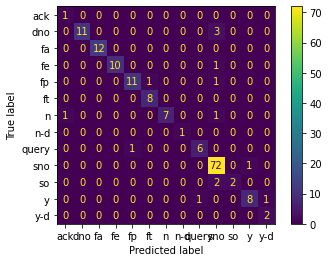

In [39]:
#get predictions 
y_pred=[]

for text in tokenized_dataset_test["test"]["text"]:
    y_pred.append(get_prediction(text))

predictions = le.inverse_transform(y_pred)
y_true = tokenized_dataset_test['test']["label"]

acc = accuracy_score(le.inverse_transform(y_true), predictions)
#f1_score = f1_score(le.inverse_transform(y_true), predictions, average="macro")
#f1_scores.append(f1_score)
results.append(acc)
print(classification_report(le.inverse_transform(y_true), predictions))
f1= f1_score(le.inverse_transform(y_true), predictions, average="macro")
f1_scores.append(f1)
cm = confusion_matrix(le.inverse_transform(y_true), predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

#le.inverse_transform([get_prediction("hi there")])[0]
